In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [13]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)

    
    
    for file_path in json_files:
        
        if "ln1" in os.path.basename(file_path): # ln1 should be ignored as its the first participant and only half of the data is not corrupt
            continue
        
        # if in filename "all_all", skip
        if "alls" in os.path.basename(file_path):
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")



Loaded 72 model fit results
Participants: ['all', 'as', 'dt', 'hh', 'ip', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior']


In [14]:
def rename_model(best_models_df, old_name, new_name):
    """Rename a model name across all relevant DataFrames and variables."""
    # Rename in df_results
    best_models_df['modelType'] = best_models_df['modelType'].replace(old_name, new_name)
    
    # Rename in best_models_df
    best_models_df['best_model'] = best_models_df['best_model'].replace(old_name, new_name)
    
    # Rename in comparison_table_df
    comparison_table_df.columns = comparison_table_df.columns.map(
        lambda col: col if col[1] != old_name else (col[0], new_name)
    )
    
    # Rename in delta_aic_table
    delta_aic_table.columns = delta_aic_table.columns.str.replace(old_name, new_name)
    
    # Rename in ll_table
    ll_table.columns = ll_table.columns.str.replace(old_name, new_name)
    
    # Rename in simple_table
    simple_table.columns = simple_table.columns.str.replace(old_name, new_name)
    
    # Update participant_best_models
    global participant_best_models
    participant_best_models = [
        new_name if model == old_name else model for model in participant_best_models
    ]
    
    # Update ll_best_models
    global ll_best_models
    ll_best_models = [
        new_name if model == old_name else model for model in ll_best_models
    ]
    
    # Print confirmation
    print(f"Model name '{old_name}' has been renamed to '{new_name}'")


In [15]:
# Find best model for each participant (lowest AIC)
def find_best_models(df_results):
    """Find the best fitting model for each participant based on AIC"""
    best_models = []
    
    for participant in df_results['participantID'].unique():
        participant_data = df_results[df_results['participantID'] == participant]
        
        if len(participant_data) > 0:
            # Find model with lowest AIC
            best_idx = participant_data['AIC'].idxmin()
            best_model = participant_data.loc[best_idx]

            # delta AIC and BIC compared to the best model
            for _, row in participant_data.iterrows():
                if row['modelType'] != best_model['modelType']:
                    delta_AIC = row['AIC'] - best_model['AIC']
                    delta_BIC = row['BIC'] - best_model['BIC']
                    print(f"Participant {participant}, Model {row['modelType']} vs Best Model {best_model['modelType']}: ΔAIC={delta_AIC:.2f}, ΔBIC={delta_BIC:.2f}")
            
            best_models.append({
                'participantID': participant,
                'best_model': best_model['modelType'],
                'AIC': best_model['AIC'],
                'BIC': best_model['BIC'],
                'logLikelihood': best_model['logLikelihood'],
                'delta_AIC': delta_AIC,
                'delta_BIC': delta_BIC
            })
    
    return pd.DataFrame(best_models)

# Find best models
best_models_df = find_best_models(df_results)
print("\nBest Model for Each Participant (based on AIC):")
print("=" * 60)
print(best_models_df.round(3))

# Model performance summary
print(f"\nModel Performance Summary:")
print("=" * 40)
model_counts = best_models_df['best_model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(best_models_df)) * 100
    print(f"{model}: {count} participants ({percentage:.1f}%)")

Participant sx, Model lognorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=13.88, ΔBIC=9.57
Participant sx, Model logLinearMismatch_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=32.11, ΔBIC=27.80
Participant sx, Model fusionOnlyLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=8.57, ΔBIC=-0.04
Participant sx, Model selection_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=6.80, ΔBIC=2.49
Participant sx, Model probabilityMatchingLogNorm_sharedPrior vs Best Model switchingFree_sharedPrior: ΔAIC=15.01, ΔBIC=10.70
Participant mt, Model fusionOnlyLogNorm_sharedPrior vs Best Model lognorm_sharedPrior: ΔAIC=1.06, ΔBIC=-2.82
Participant mt, Model probabilityMatchingLogNorm_sharedPrior vs Best Model lognorm_sharedPrior: ΔAIC=9.17, ΔBIC=9.17
Participant mt, Model logLinearMismatch_sharedPrior vs Best Model lognorm_sharedPrior: ΔAIC=12.49, ΔBIC=12.49
Participant mt, Model selection_sharedPrior vs Best Model lognorm_sharedPrior: ΔAIC=14.68, ΔBIC=1

In [16]:
# Rename models in df_results BEFORE creating any tables
df_results['modelType'] = df_results['modelType'].replace({
    'probabilityMatchingLogNorm_sharedPrior': 'prob-Matching-Log',
    'probabilityMatchingLogNorm': 'prob-Matching',
    'probabilityMatching_sharedPrior': 'prob-Matching-Gauss',
    'switchingFree_sharedPrior': 'Free Switching',
    'switching_sharedPrior': 'Noise Dep. Switching',
    'switchingWithConflict_sharedPrior': 'Noise Dep. Switching + Conflict',
    'fusionOnly_sharedPrior': 'Fusion Only',
    'fusionOnlyLogNorm_sharedPrior': 'Fusion Only-Log',
    'lognorm_sharedPrior': 'Log-Space Causal',
    'gaussian_sharedPrior': 'Gaussian-Space Causal',
    'lognorm_contextualPrior': 'Log-Space Causal + Context'
})

df_results["nParameters"] = [len(params) for params in df_results["fittedParams"]]
df_results["AIC_recalculated"] = 2 * df_results["nParameters"] - 2 * df_results["logLikelihood"]

print("Model names updated successfully!")
print(f"Current model types: {sorted(df_results['modelType'].unique())}")

Model names updated successfully!
Current model types: ['Free Switching', 'Fusion Only-Log', 'Log-Space Causal', 'logLinearMismatch_sharedPrior', 'prob-Matching-Log', 'selection_sharedPrior']


In [17]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated
0,sx,Free Switching,"[0.0010000761032104288, 0.0684153325366973, 0....",2141.076250,2175.526452,-1062.538125,548,8,2141.076250
1,sx,Log-Space Causal,"[0.0010043366753030303, 0.3135373390298103, 0....",2154.951824,2185.095751,-1070.475912,548,7,2154.951824
2,sx,logLinearMismatch_sharedPrior,"[0.032859806000393364, 0.2476851209303061, 0.2...",2173.184572,2203.328499,-1079.592286,548,7,2173.184572
3,sx,Fusion Only-Log,"[0.001000086629595498, 0.30521380870952497, 0....",2149.645484,2175.483135,-1068.822742,548,6,2149.645484
4,sx,selection_sharedPrior,"[0.051137719284647803, 0.17340518760795887, 0....",2147.875927,2178.019854,-1066.937963,548,7,2147.875927
...,...,...,...,...,...,...,...,...,...
67,ip,selection_sharedPrior,"[0.28124853283969, 0.0843586400485572, 0.43919...",2445.854220,2475.257785,-1215.927110,493,7,2445.854220
68,ip,prob-Matching-Log,"[0.13731397299786485, 0.2426780805811527, 0.76...",2408.195038,2437.598602,-1197.097519,493,7,2408.195038
69,ip,Log-Space Causal,"[0.14247516427040102, 0.2335343058657645, 1.14...",2406.054179,2435.457743,-1196.027089,493,7,2406.054179
70,ip,logLinearMismatch_sharedPrior,"[0.1911488932291989, 0.19594522194790084, 0.89...",2412.412694,2441.816258,-1199.206347,493,7,2412.412694


Participants sorted by sum of delta_AIC across all models (lowest to highest):
Delta_AIC sums: {'dt': 15.643140655192838, 'as': 22.77289577252577, 'oy': 39.85656697675495, 'mt': 48.35771581245126, 'qs': 48.98262828312454, 'ip': 59.012400438345594, 'ln2': 62.3211046350948, 'hh': 62.72255761717702, 'sx': 76.36245080970957, 'mh': 79.75360406812706, 'ml': 85.97841100352525, 'all': 459.5987844610536}


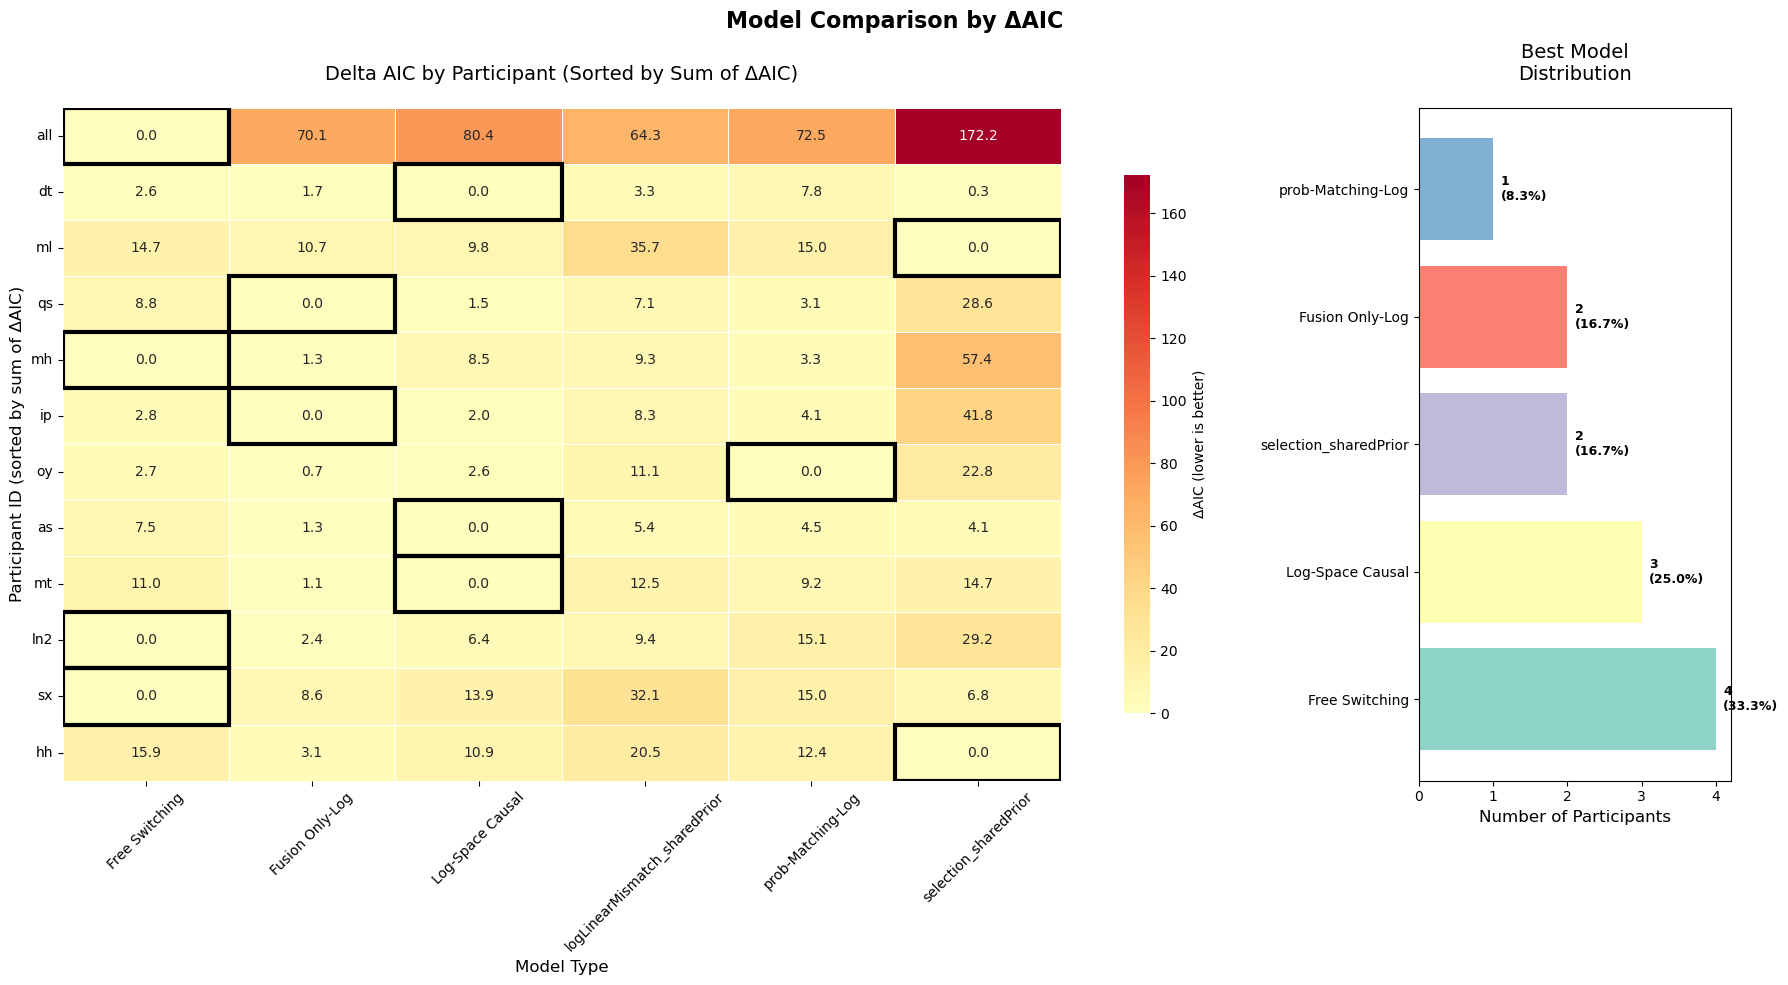

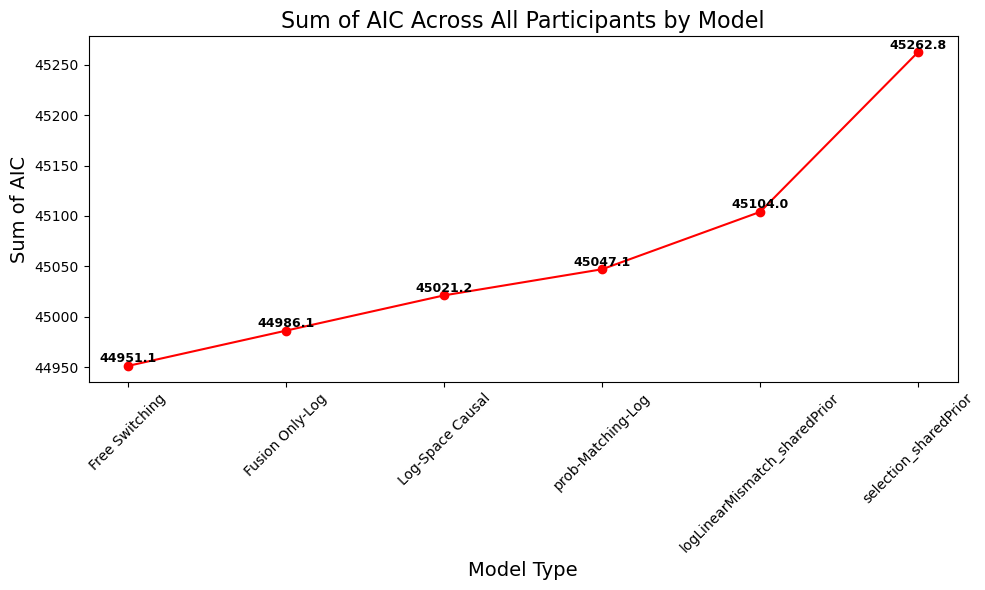

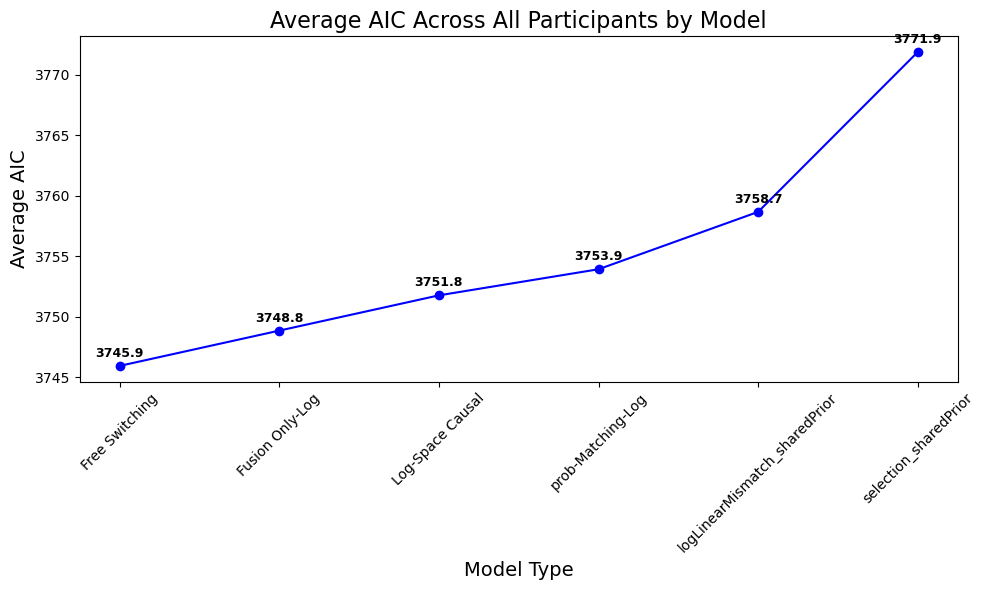


PARTICIPANT RANKING TABLE (sorted by sum of ΔAIC across all models)
Rank Participant  Sum Δ      Best Model         Min Δ      Performance    
------------------------------------------------------------------------------------------
1    all          121866.5   Free Switching     20234.5    Poor fit       
2    dt           15326.9    Log-Space Causal   2551.9     Poor fit       
3    ml           15083.8    selection_sharedPrior 2499.6     Poor fit       
4    qs           15020.5    Fusion Only-Log    2495.3     Poor fit       
5    mh           14635.6    Free Switching     2426.0     Poor fit       
6    ip           14483.5    Fusion Only-Log    2404.1     Poor fit       
7    oy           13988.8    prob-Matching-Log  2324.8     Poor fit       
8    as           13531.8    Log-Space Causal   2251.5     Poor fit       
9    mt           13216.0    Log-Space Causal   2194.6     Poor fit       
10   ln2          13082.6    Free Switching     2170.1     Poor fit       
11   sx     

In [23]:
# Calculate delta_AIC for each model relative to the best model per participant
df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())

# Sort participants by sum of delta_AIC across all models (lower sum = better overall performance)
participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
sorted_participants = participant_delta_sums.index.tolist()
print("Participants sorted by sum of delta_AIC across all models (lowest to highest):")
print(f"Delta_AIC sums: {participant_delta_sums.to_dict()}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create enhanced table-style visualization
def plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=1, sumCompBase=0):
    
    if notFusion:
        removeModels= ["Fusion Only", "Fusion Only-Log"]
        df_results = df_results[~df_results['modelType'].isin(removeModels)]
    """Create a comprehensive table plot with participants sorted by sum of delta_AIC"""
    
    # Calculate delta_AIC for each model relative to the best model
    df_results['delta_AIC'] = df_results.groupby('participantID')[compBase].transform(lambda x: x - x.min())
    
    # Sort participants by sum of delta_AIC across all models
    participant_delta_sums = df_results.groupby('participantID')['logLikelihood'].sum().sort_values()
    sorted_participants = participant_delta_sums.index.tolist()
    
    # Create the pivot table with sorted participants
    df_delta_aic = df_results.pivot(index='participantID', columns='modelType', values='delta_AIC')
    df_delta_aic = df_delta_aic.reindex(sorted_participants)
    
    # Find best model for each participant
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle(f'Model Comparison by Δ{compBase}', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta_AIC values
    sns.heatmap(df_delta_aic, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': f'Δ{compBase} (lower is better)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title(f'Delta {compBase} by Participant (Sorted by Sum of Δ{compBase})', fontsize=14, pad=20)
    ax1.set_ylabel(f'Participant ID (sorted by sum of Δ{compBase})', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_aic.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a star or border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Model\nDistribution', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # we want to plot a line chart of sum of AIC per model
    model_sums = df_results.groupby('modelType')[compBase].sum().sort_values()
    plt.figure(figsize=(10, 6))
    plt.plot(model_sums.index, model_sums.values, marker='o', linestyle='-', color='r')
    plt.title(f'Sum of {compBase} Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel(f'Sum of {compBase}', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    # Add value labels on points
    for i, value in enumerate(model_sums.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Another plot to show average AIC per model as a line plot
    model_means = df_results.groupby('modelType')[compBase].mean().sort_values()
    plt.figure(figsize=(10, 6))
    plt.plot(model_means.index, model_means.values, marker='o', linestyle='-', color='b')
    # Add value labels on points
    for i, value in enumerate(model_means.values):
        plt.text(i, value + 0.5, f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.title(f'Average {compBase} Across All Participants by Model', fontsize=16)
    plt.xlabel('Model Type', fontsize=14)
    plt.ylabel(f'Average {compBase}', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


    
    # Print summary table
    print("\n" + "="*90)
    print(f"PARTICIPANT RANKING TABLE (sorted by sum of Δ{compBase} across all models)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Sum Δ':<10} {'Best Model':<18} {'Min Δ ':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data[compBase].sum()
        min_delta_aic = participant_data[compBase].min()
        best_model = participant_data.loc[participant_data[compBase].idxmin(), 'modelType']
        
        if sum_delta_aic <= 5:
            performance = "Excellent fit"
        elif sum_delta_aic <= 15:
            performance = "Good fit"
        elif sum_delta_aic <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_aic:<10.1f} {best_model:<18} {min_delta_aic:<10.1f} {performance:<15}")
    
    return df_delta_aic, best_models, participant_delta_sums

# Create the enhanced visualization
delta_aic_table, participant_best_models, delta_sums = plot_sorted_model_comparison_table(df_results,compBase='AIC', notFusion=0,sumCompBase=1)

In [19]:
# Simple Model Comparison Table with Log Likelihoods
def create_simple_comparison_table(df_results):
    """Create a simple comparison table focused on log likelihoods"""
    
    # Pivot to show log likelihoods for each participant-model combination
    log_likelihood_table = df_results.pivot(
        index='participantID', 
        columns='modelType', 
        values='logLikelihood'
    )
    
    # Sort participants by ID for consistent ordering
    log_likelihood_table = log_likelihood_table.sort_index()
    
    return log_likelihood_table

# Create the simple comparison table
simple_table = create_simple_comparison_table(df_results)

print("Model Comparison Table - Log Likelihoods")
print("=" * 80)
print("Higher values indicate better fit")
print("=" * 80)
print()

# Display with better formatting
pd.set_option('display.float_format', '{:.2f}'.format)
display(simple_table)

# Reset display options
pd.reset_option('display.float_format')

Model Comparison Table - Log Likelihoods
Higher values indicate better fit



modelType,Free Switching,Fusion Only-Log,Log-Space Causal,logLinearMismatch_sharedPrior,prob-Matching-Log,selection_sharedPrior
participantID,,,,,,
all,-10109.24,-10146.31,-10150.46,-10142.39,-10146.50,-10196.33
as,-1121.52,-1120.39,-1118.76,-1121.48,-1121.00,-1120.78
dt,-1269.22,-1270.81,-1268.94,-1270.57,-1272.84,-1269.07
hh,-595.84,-591.45,-594.37,-599.14,-595.08,-588.90
ip,-1195.44,-1196.04,-1196.03,-1199.21,-1197.10,-1215.93
ln2,-1077.03,-1080.21,-1081.21,-1082.71,-1085.56,-1092.60
mh,-1204.98,-1207.63,-1210.25,-1210.61,-1207.63,-1234.68
ml,-1249.19,-1249.18,-1247.71,-1260.67,-1250.32,-1242.81
mt,-1094.78,-1091.83,-1090.30,-1096.55,-1094.89,-1097.64


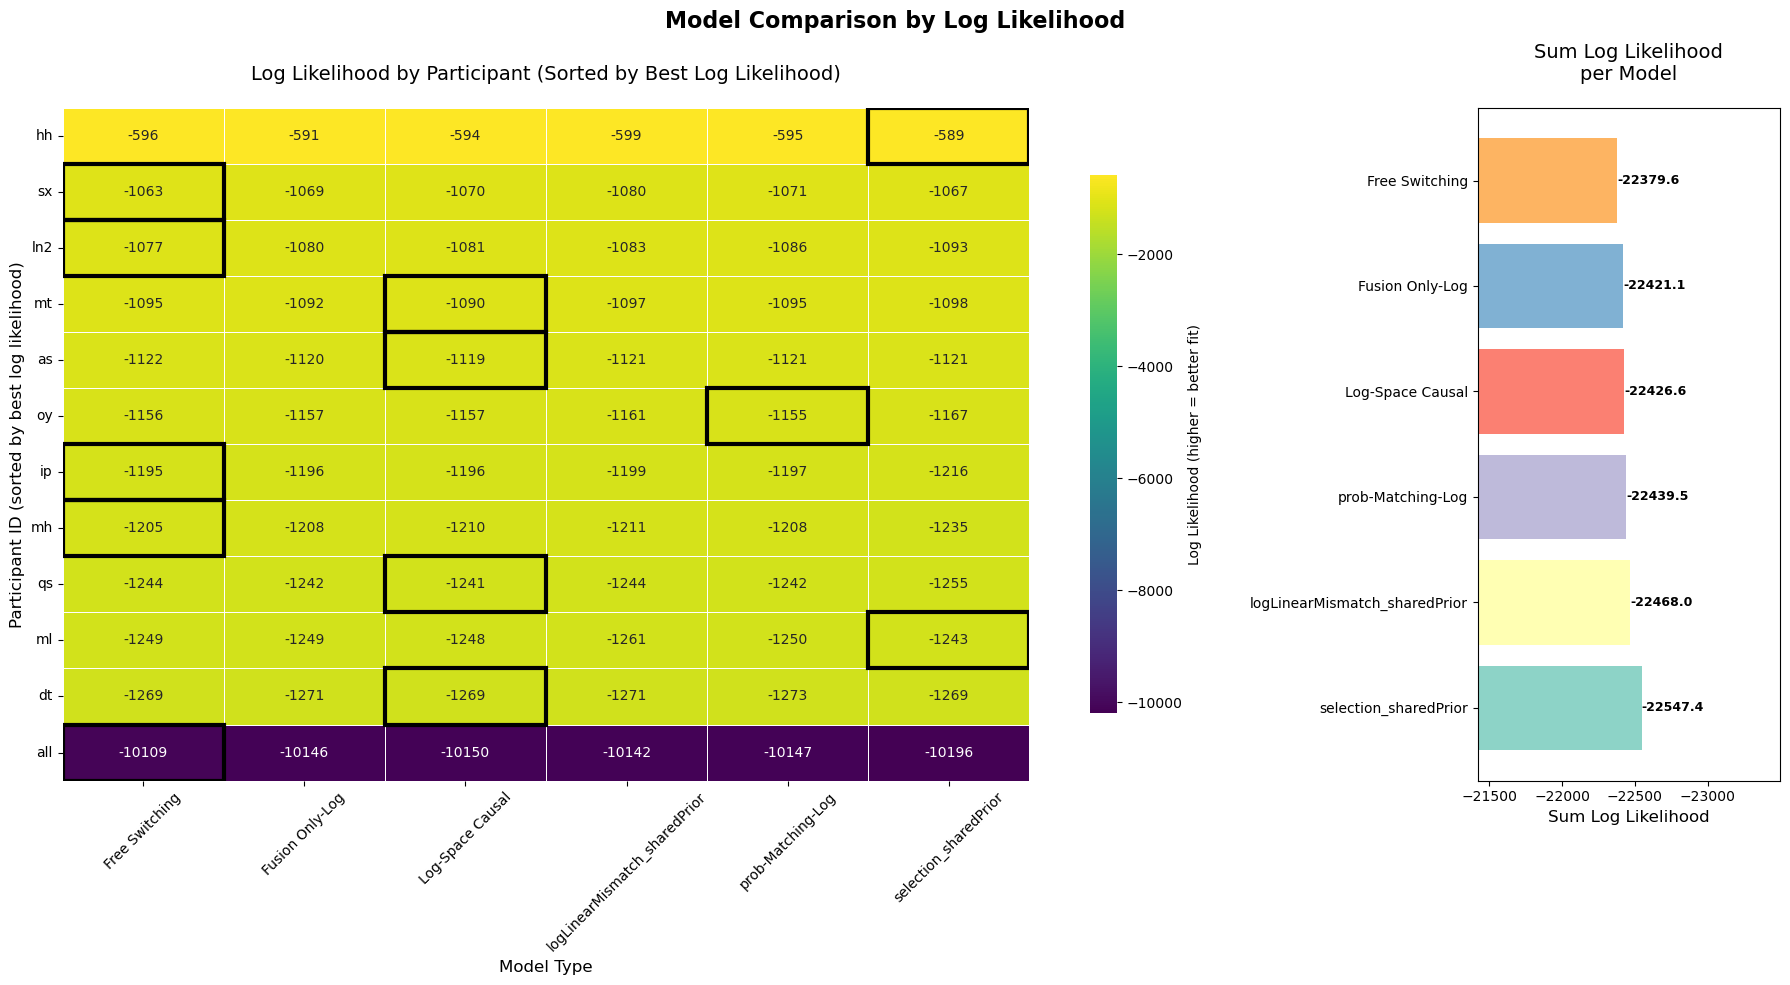


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    hh           -589       selection_sharedPrior 62.7       Excellent fit  
2    sx           -1063      Free Switching     76.4       Moderate fit   
3    ln2          -1077      Free Switching     62.3       Moderate fit   
4    mt           -1090      Log-Space Causal   48.4       Moderate fit   
5    as           -1119      Log-Space Causal   22.8       Moderate fit   
6    oy           -1155      prob-Matching-Log  39.9       Moderate fit   
7    ip           -1195      Free Switching     59.0       Moderate fit   
8    mh           -1205      Free Switching     79.8       Poor fit       
9    qs           -1241      Log-Space Causal   49.0       Poor fit       
10   ml           -1243      selection_sharedPrior 86.0       Poor fit       
11   dt           -

In [20]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns


def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Sum Log Likelihood per model - sum across rows (participants) for each model column
    sum_ll = df_log_likelihood.sum(axis=0).sort_values()  # sum across participants for each model
    colors = plt.cm.Set3(range(len(sum_ll)))
    
    bars = ax2.barh(range(len(sum_ll)), sum_ll.values, color=colors)
    ax2.set_yticks(range(len(sum_ll)))
    ax2.set_yticklabels(sum_ll.index, fontsize=10)
    ax2.set_xlabel('Sum Log Likelihood', fontsize=12)
    ax2.set_title('Sum Log Likelihood\nper Model', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sum_ll.values)):
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}',
                 ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Set limits for the heatmap axes
    ax2.set_xlim(min(sum_ll.values)*0.95, max(sum_ll.values)*1.05)

    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models
# ...existing code...

    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

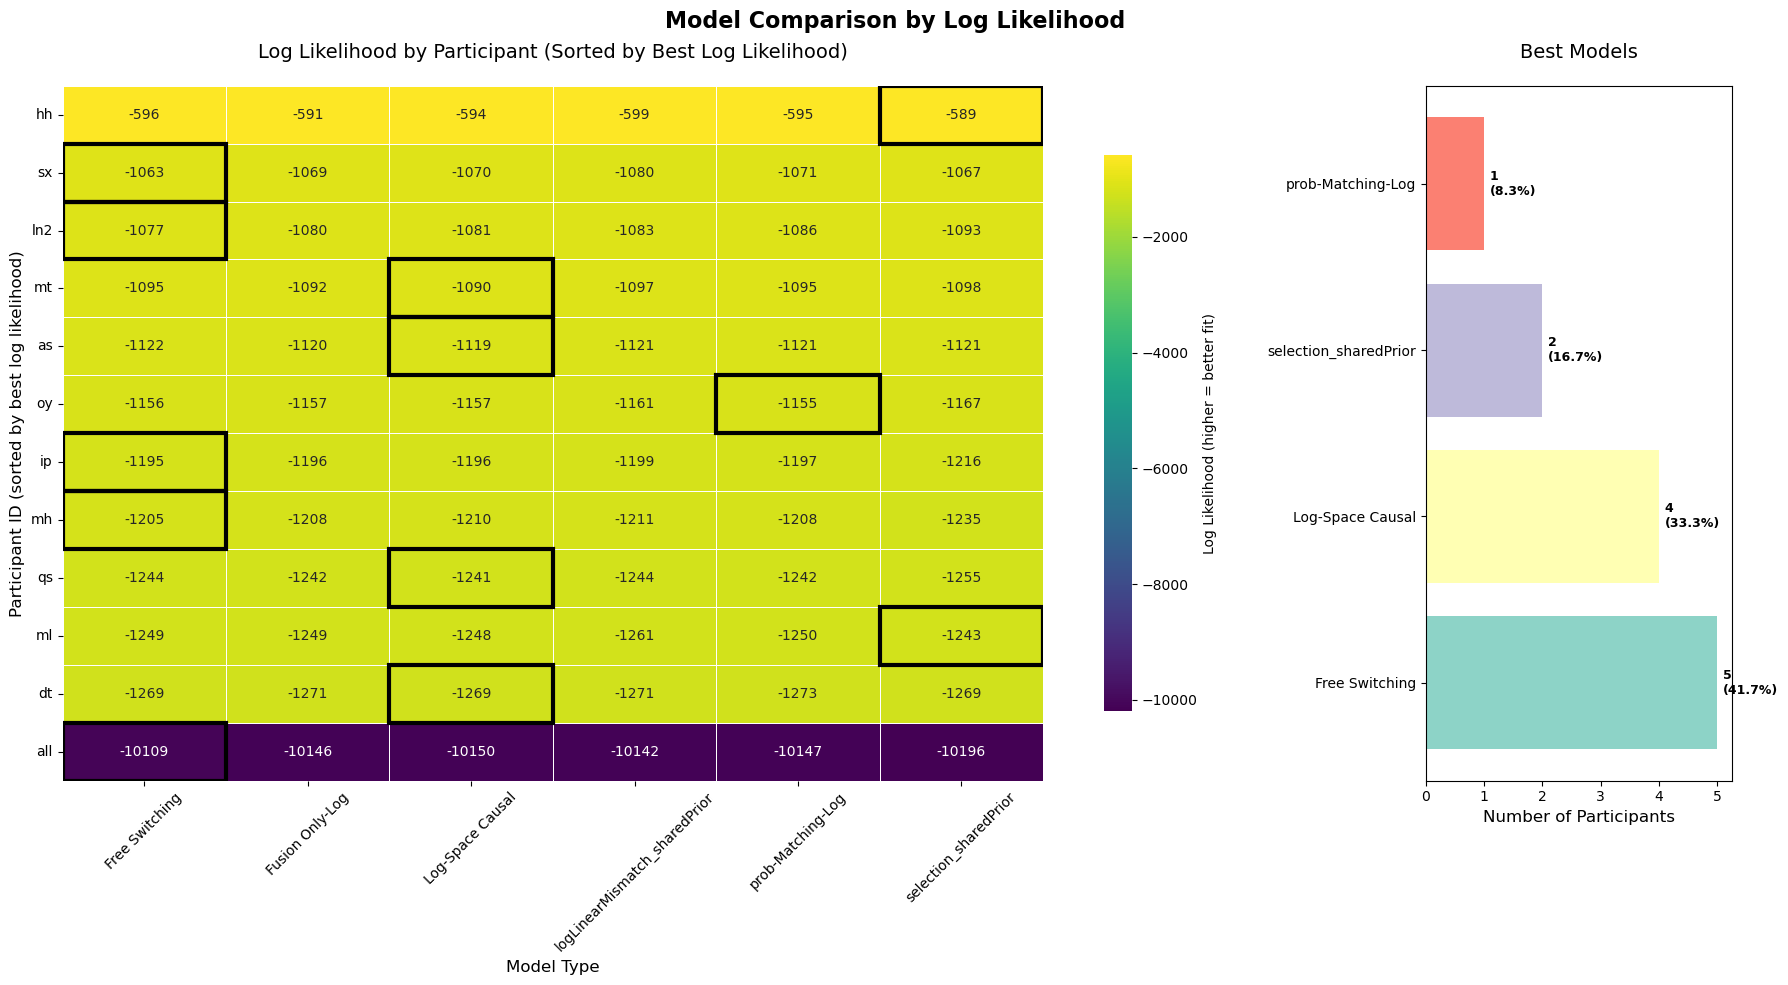


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    hh           -589       selection_sharedPrior 62.7       Excellent fit  
2    sx           -1063      Free Switching     76.4       Moderate fit   
3    ln2          -1077      Free Switching     62.3       Moderate fit   
4    mt           -1090      Log-Space Causal   48.4       Moderate fit   
5    as           -1119      Log-Space Causal   22.8       Moderate fit   
6    oy           -1155      prob-Matching-Log  39.9       Moderate fit   
7    ip           -1195      Free Switching     59.0       Moderate fit   
8    mh           -1205      Free Switching     79.8       Poor fit       
9    qs           -1241      Log-Space Causal   49.0       Poor fit       
10   ml           -1243      selection_sharedPrior 86.0       Poor fit       
11   dt           -

In [21]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='black', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Models', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)

In [11]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions,nParameters,AIC_recalculated,delta_AIC
0,sx,Free Switching,"[0.0010000761032104288, 0.0684153325366973, 0....",2141.076250,2175.526452,-1062.538125,548,8,2141.076250,0.000000
1,sx,Log-Space Causal,"[0.0010043366753030303, 0.3135373390298103, 0....",2154.951824,2185.095751,-1070.475912,548,7,2154.951824,13.875574
2,sx,logLinearMismatch_sharedPrior,"[0.032859806000393364, 0.2476851209303061, 0.2...",2173.184572,2203.328499,-1079.592286,548,7,2173.184572,32.108322
3,sx,Fusion Only-Log,"[0.001000086629595498, 0.30521380870952497, 0....",2149.645484,2175.483135,-1068.822742,548,6,2149.645484,8.569234
4,sx,selection_sharedPrior,"[0.051137719284647803, 0.17340518760795887, 0....",2147.875927,2178.019854,-1066.937963,548,7,2147.875927,6.799677
...,...,...,...,...,...,...,...,...,...,...
73,ip,selection_sharedPrior,"[0.28124853283969, 0.0843586400485572, 0.43919...",2445.854220,2475.257785,-1215.927110,493,7,2445.854220,41.775764
74,ip,prob-Matching-Log,"[0.13731397299786485, 0.2426780805811527, 0.76...",2408.195038,2437.598602,-1197.097519,493,7,2408.195038,4.116581
75,ip,Log-Space Causal,"[0.14247516427040102, 0.2335343058657645, 1.14...",2406.054179,2435.457743,-1196.027089,493,7,2406.054179,1.975723
76,ip,logLinearMismatch_sharedPrior,"[0.1911488932291989, 0.19594522194790084, 0.89...",2412.412694,2441.816258,-1199.206347,493,7,2412.412694,8.334238


Participant all: lambda_1=0.11589890208712304, sigma_a=0.2517122574149462, sigma_v=0.3684426792147451, p_c=0.7718420782005057,sigma_a2=0.6582841291304623, lambda_2=0.1194144664629676, lambda_3=0.2026190064036911
Participant as: lambda_1=0.0774992083677648, sigma_a=0.2405821350876688, sigma_v=0.4112880736504606, p_c=0.45352246591641004,sigma_a2=0.6729185152573023, lambda_2=0.07742735916205717, lambda_3=0.02189801737643257
Participant dt: lambda_1=0.27528706140859727, sigma_a=0.20040147823414955, sigma_v=0.3216995828125505, p_c=0.5244267333768221,sigma_a2=0.5474633302867078, lambda_2=0.19619577890732326, lambda_3=0.22246536564921154
Participant hh: lambda_1=0.0010000002972781474, sigma_a=0.11218579366922365, sigma_v=0.2629771921456977, p_c=0.9737051330506803,sigma_a2=1.9928057438302784, lambda_2=0.0010137889504432673, lambda_3=0.061968152067810284
Participant ip: lambda_1=0.14247516427040102, sigma_a=0.2335343058657645, sigma_v=1.143277091217041, p_c=0.9997496843338014,sigma_a2=0.6232884

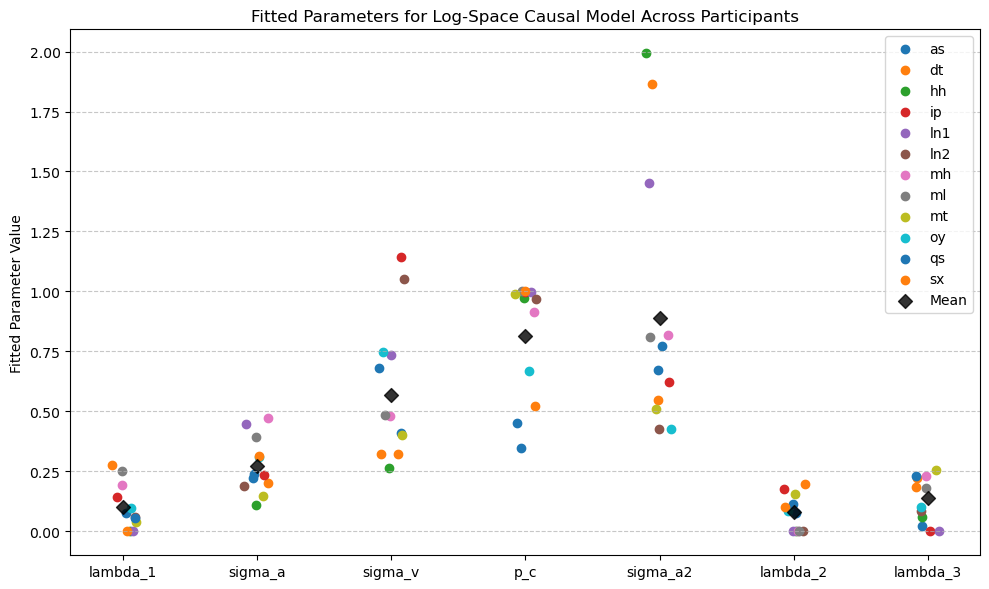

In [12]:
import numpy as np
import matplotlib.pyplot as plt
def plot_parameter_fits(df_results,model_name='Log-Space Causal'):
    # example fittedParams for Log-Space Causal model
    # fittedParams: [lambda_1, sigma_a, sigma_v, sigma_a2,lambda_2, lambda_3]
    participantIDs= sorted(df_results['participantID'].unique())
    modelTypes= sorted(df_results['modelType'].unique())
    paramFits= {}
    for pid in participantIDs:
        participant_data = df_results[df_results['participantID'] == pid]
        pid_lognorm_fit = participant_data[participant_data['modelType'] == model_name]
        lambda_1_Fit = pid_lognorm_fit['fittedParams'].values[0][0]
        sigma_a_Fit = pid_lognorm_fit['fittedParams'].values[0][1]
        sigma_v_Fit = pid_lognorm_fit['fittedParams'].values[0][2]
        p_c= pid_lognorm_fit['fittedParams'].values[0][3]
        sigma_a2_Fit = pid_lognorm_fit['fittedParams'].values[0][4]
        lambda_2_Fit = pid_lognorm_fit['fittedParams'].values[0][5]
        lambda_3_Fit = pid_lognorm_fit['fittedParams'].values[0][6]    
        print(f"Participant {pid}: lambda_1={lambda_1_Fit}, sigma_a={sigma_a_Fit}, sigma_v={sigma_v_Fit}, p_c={p_c},sigma_a2={sigma_a2_Fit}, lambda_2={lambda_2_Fit}, lambda_3={lambda_3_Fit}")
        paramFits[pid]= {
            'lambda_1': lambda_1_Fit,
            'sigma_a': sigma_a_Fit,
            'sigma_v': sigma_v_Fit,
            'p_c': p_c,
            'sigma_a2': sigma_a2_Fit,
            'lambda_2': lambda_2_Fit,
            'lambda_3': lambda_3_Fit
        }

    




    # plot the parameter fits scatter plot with jittered x-axis values for each parameter
    plt.figure(figsize=(10, 6))
    parameters = ['lambda_1', 'sigma_a', 'sigma_v', 'p_c', 'sigma_a2', 'lambda_2', 'lambda_3']
    x_positions = np.arange(len(parameters))
    for pid in participantIDs:
        if pid=='all':
            # color='red'
            # fits = paramFits[pid]
            # y_values = [fits[param] for param in parameters]
            # plt.scatter(x_positions, y_values, label=pid, color=color, s=100, edgecolor='red')
            continue
        fits = paramFits[pid]
        y_values = [fits[param] for param in parameters]
        # Add jitter to x positions
        jitter = np.random.uniform(-0.1, 0.1, size=len(parameters))
        plt.scatter(x_positions + jitter, y_values, label=pid)

    # Add mean markers for each parameter
    for i, param in enumerate(parameters):
        mean_value = np.mean([paramFits[pid][param] for pid in participantIDs])
        plt.scatter(i, mean_value, color='black', marker='D', s=50, alpha=0.8,label='Mean' if i == 0 else "")

    plt.xticks(x_positions, parameters)
    plt.ylabel('Fitted Parameter Value')
    plt.title('Fitted Parameters for Log-Space Causal Model Across Participants')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_parameter_fits(df_results,model_name='Log-Space Causal')